In [1]:
import ibmJupyterNotebookStyles
ibmJupyterNotebookStyles.apply_ibm_styles()

# Initial states & Qiskit demo
<a id="Introduction"></a>
## Introduction

In this notebook, we will introduce the concept of initial states. We will then demonstrate how to apply the variational forms you previously learned to an initial state to carry out a VQE calculation, in order to find the ground state energy of a hydrogen molecule using a minimal basis set.

<img src="figs/vqe.png" width="700">

## The Hartree-Fock initial state 

A good starting point for solving this problem is the Hartree-Fock (HF) method. This method approximates an N-body problem into N one-body problems, where each electron evolves in the mean-field of the others. Classically solving the HF equations is efficient and leads to the exact exchange energy, but does not include any electron correlation. Therefore, it is usually a good starting point to start adding correlation. 

The Hamiltonian can then be re-expressed in the basis of the solutions of the HF method, also called Molecular Orbitals (MOs):

$$
\hat{H}_{elec}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q + 
\frac{1}{2} \sum_{pqrs} h_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$
with the one-body integrals
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{R_I- r} \right)   \phi_q(r)
$$
and two-body integrals
$$
h_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|r_1-r_2|}
$$

In the second-quantized Hamiltonian $\hat{H}_{elec}$, the MOs ($\phi_u$) can be occupied or virtual (unoccupied). One MO can contain two electrons. However, in what follows, we actually work with spin orbitals, which are associated with a spin-up ($\alpha$) or spin-down ($\beta$) electron. Thus, spin orbitals can contain one electron or be unoccupied. The qubits are initialized in the HF initial state, the qubits corresponding to occupied MOs are $|1\rangle$, and those corresponding to virtual MOs are $|0\rangle$.

Qiskit interfaces with different classical quantum chemistry codes that can find the HF solutions. Interfacing between Qiskit and the following codes is already available: Gaussian, Psi4, PyQuante, and PySCF.

## VQE implementation in Qiskit

We demonstrate the calculation of the ground state energy for the hydrogen molecule H$_2$ at equilibrium bond length (0.735 angstrom) using the STO-3G basis set. <br>

How many spin orbitals are there in this system? <br>
<font size="2.5"> 
The basis functions represent the molecular orbitals. STO-3G is a "minimal basis set". Minimal basis sets made up of the simplest kind of contracted Gaussian (CG) functions are the STO-nG basis sets. These basis sets approximate Slater-type orbitals (STOs) by $n$ primitive Gaussians. They are "minimal" because they include only one CG per atomic orbital. <br>
The molecular hydrogen molecule in STO-3G basis is described by two localized atomic spatial wavefunction $1S$, each centered on a hydrogen atom $| 1S_1 \rangle$ and $| 1S_2 \rangle$. We can construct the linear combinations of these two orbitals:    <br>
$| \psi_g \rangle = | 1S_1 \rangle + | 1S_2 \rangle$ <br>
$| \psi_u \rangle = | 1S_1 \rangle - | 1S_2 \rangle$ <br>
($u$ is ungerade - odd and $g$ is gerade - even) <br>
Consequently, four molecular spin orbitals are formed by taking the product of these two molecular spatial orbitals with one of two orthogonal spin functions, $| \alpha \rangle$ (spin up) and $| \beta \rangle$ (spin down):<br>
$| \theta_0 \rangle =  | \psi_g \rangle |\alpha \rangle$ <br>
$| \theta_1 \rangle =  | \psi_g \rangle |\beta \rangle$ <br>
$| \theta_2 \rangle =  | \psi_u \rangle |\alpha \rangle$ <br>
$| \theta_3 \rangle =  | \psi_u \rangle |\beta \rangle$
</font> 

<img src="figs/H2_gs.png" width="150">


The first step is to define the molecular system. In the following we ask for the electronic part of a hydrogen molecule.

In [2]:
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(
    atom="H 0 0 0; H 0 0 0.735",
    basis="sto3g",
    charge=0,
    spin=0,
    unit=DistanceUnit.ANGSTROM,
)


We achieve it through the use of the PySCF driver. 

PySCF is an open-source library for computational chemistry. In order for Qiskit Nature to interface PySCF and execute PySCF to extract the electronic structure information, PySCF must be installed.

According to the PySCF installation instructions, the preferred installation method is via the pip package management system. Doing so, while in the Python virtual environment where Qiskit Nature is also installed, will automatically make PySCF available to Qiskit at run time.

Next, we set up the Electronic Structure Problem to generate the second-quantized operator and then map it to a qubit operator.

In [3]:
problem = driver.run()
print(problem)

/Users/lcd/github/gbs-ibm-q/fixes/asset-lib-code-base/Essentials/Chemistry/test-env/lib/python3.10/site-packages/pyscf/dft/libxc.py:771: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [4]:
hamiltonian = problem.hamiltonian

coefficients = hamiltonian.electronic_integrals
print(coefficients.alpha)

Polynomial Tensor
 "+-":
array([[-1.25633907e+00, -1.37083854e-17],
       [-3.92720783e-17, -4.71896007e-01]])
 "++--":
array([6.75710155e-01, 8.69283836e-17, 1.80931200e-01, 6.64581730e-01,
       2.25343262e-16, 6.98573723e-01])


In [5]:
second_q_op = hamiltonian.second_q_op()
print(second_q_op)

Fermionic Operator
number spin orbitals=4, number terms=36
  -1.25633907300325 * ( +_0 -_0 )
+ -0.47189600728114184 * ( +_1 -_1 )
+ -1.25633907300325 * ( +_2 -_2 )
+ -0.47189600728114184 * ( +_3 -_3 )
+ 0.3378550774017583 * ( +_0 +_0 -_0 -_0 )
+ 0.3322908651276482 * ( +_0 +_1 -_1 -_0 )
+ 0.3378550774017583 * ( +_0 +_2 -_2 -_0 )
+ 0.3322908651276482 * ( +_0 +_3 -_3 -_0 )
+ 0.09046559989211572 * ( +_0 +_0 -_1 -_1 )
+ 0.09046559989211572 * ( +_0 +_1 -_0 -_1 )
+ 0.09046559989211572 * ( +_0 +_2 -_3 -_1 )
+ 0.09046559989211572 * ( +_0 +_3 -_2 -_1 )
+ 0.09046559989211572 * ( +_1 +_0 -_1 -_0 )
+ 0.09046559989211572 * ( +_1 +_1 -_0 -_0 )
+ 0.09046559989211572 * ( +_1 +_2 -_3 -_0 )
+ 0.09046559989211572 * ( +_1 +_3 -_2 -_0 )
+ 0.3322908651276482 * ( +_1 +_0 -_0 -_1 )
+ 0.34928686136600906 * ( +_1 +_1 -_1 -_1 )
+ 0.3322908651276482 * ( +_1 +_2 -_2 -_1 )
+ 0.34928686136600906 * ( +_1 +_3 -_3 -_1 )
+ 0.3378550774017583 * ( +_2 +_0 -_0 -_2 )
+ 0.3322908651276482 * ( +_2 +_1 -_1 -_2 )
+ 0.33785507740

In [6]:
hamiltonian.nuclear_repulsion_energy  # NOT included in the second_q_op above

0.7199689944489797

We can now transform this Hamiltonian to our qubit operator using a mapping scheme, such as Jordan-Wigner:

In [7]:
from qiskit_nature.second_q.mappers import JordanWignerMapper

mapper = JordanWignerMapper()

In [8]:
#The qiskit.opflow module is going to be deprecated in the future. 
#In order to transition from the PauliSumOp class and its widespread use to the qiskit.quantum_info module and its SparsePauliOp class, you can now set the value of use_pauli_sum_op to False. 
#This will become the default in a later release.

from qiskit_nature import settings

settings.use_pauli_sum_op = False

qubit_op = mapper.map(second_q_op)

for pauli, coeff in sorted(qubit_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-0.81054798 * IIII
+0.17218393 * IIIZ
-0.22575349 * IIZI
+0.12091263 * IIZZ
+0.17218393 * IZII
+0.16892754 * IZIZ
+0.16614543 * IZZI
+0.04523280 * XXXX
+0.04523280 * XXYY
+0.04523280 * YYXX
+0.04523280 * YYYY
-0.22575349 * ZIII
+0.16614543 * ZIIZ
+0.17464343 * ZIZI
+0.12091263 * ZZII


As shown above, we require four qubits in this basis set - one for each spin orbital. The Jordan-Wigner mapping is particularly interesting as it maps each spin orbital to a qubit. We can reduce the number of qubits by using the parity mapping, which allows us to remove two qubits by exploiting known symmetries arising from the mapping. 

To learn more about the various mappers available in Qiskit Nature, check out the Qubit Mappers tutorial.

In [9]:
from qiskit_nature.second_q.mappers import ParityMapper

mapper = ParityMapper(num_particles=problem.num_particles)

qubit_p_op = mapper.map(second_q_op)

for pauli, coeff in sorted(qubit_p_op.label_iter()):
    print(f"{coeff.real:+.8f} * {pauli}")

-1.05237325 * II
+0.39793742 * IZ
+0.18093120 * XX
-0.39793742 * ZI
-0.01128010 * ZZ


To learn more about the various mappers available in Qiskit Nature, check out the Qubit Mappers tutorial.

### The Solver
We now need to define a solver. The solver is the algorithm through which we compute the ground state.
Let's first start with a purely classical example: the NumPy minimum eigensolver. This algorithm exactly diagonalizes the Hamiltonian. Although it scales badly, we can use it on small systems to check the results of the quantum algorithms.

#### Exact solver

In [10]:
from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver

numpy_solver = NumPyMinimumEigensolver()

calc = GroundStateEigensolver(mapper, numpy_solver)

res_exact = calc.solve(problem)

### VQE

Next we will carry out VQE calculations, then compare the VQE results to the reference result from the NumPy exact solver and see that they match.

To define the VQE solver one needs three essential elements:

1. An Estimator primitive: these were released as part of Qiskit Terra 0.22. To learn more about primitives, check out [this resource](https://qiskit.org/documentation/apidoc/primitives.html).
2. A variational form: here we use the Unitary Coupled Cluster (UCC) ansatz (see for instance [Physical Review A 98.2 (2018): 022322]). Since it is a chemistry standard, a factory is already available allowing a fast initialization of a VQE with UCC. The default is to use all single and double excitations. However, the excitation type (S, D, SD) as well as other parameters can be selected. The `UCCSD` variational form is set up with a `HartreeFock` initial state, which initializes the occupation of our qubits according to the problem which we are trying solve.
3. An optimizer: this is the classical piece of code in charge of optimizing the parameters in our variational form. See [the corresponding documentation of Qiskit Terra](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html) for more information.

#### VQE solver with HF initial state & UCCSD ansatz

In [11]:
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
    ),
)

In [12]:
import numpy as np
from qiskit_algorithms.optimizers import SLSQP
from qiskit_algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator

vqe = VQE(Estimator(), ansatz, SLSQP())

In [13]:
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint

initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = problem
vqe.initial_point = initial_point.to_numpy_array()

One could also use any available ansatz / initial state or even define one's own. For instance,


In [14]:
from qiskit.circuit.library import TwoLocal

tl_circuit = TwoLocal(
    rotation_blocks=["h", "rx"],
    entanglement_blocks="cz",
    entanglement="full",
    reps=2,
    parameter_prefix="y",
)

another_solver = VQE(Estimator(), tl_circuit, SLSQP())

## The calculation and results

We are now ready to put everything together to compute the ground-state of our problem.
Doing so requires us to wrap our `QubitConverter` and quantum algorithm into a single `GroundStateEigensolver` like so:

In [15]:
vqe_solver = GroundStateEigensolver(mapper, vqe)

This will now take of the entire workflow:
1. Generating the second-quantized operators stored in our `problem`
2. Mapping (and potentially reducing) the operators in the qubit space
3. Setting up relevant parameters based on the `problem`
4. Running the quantum algorithm on the Hamiltonian qubit operator
5. Once converged, evaluating the additional observables at the determined ground state

In [16]:
res_vqe = vqe_solver.solve(problem)

print(f"Total ground state energy = {res_vqe.total_energies[0]:.4f}")

Total ground state energy = -1.1373


In [17]:
print('VQE results:\n', res_vqe)

VQE results:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030145
  - computed part:      -1.857275030145
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035696
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948767747]
    - computed part:      [0.0  0.0  1.388948767747]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000067747]  Total: 0.000000067747
                 (debye): [0.0  0.0  -0.000000172195]  Total: 0.000000172195
 


We can compare the VQE results to the NumPy exact solver and see that they match. 

In [18]:
print('Exact results:\n', res_exact)

Exact results:
 === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.388948701555]
    - computed part:      [0.0  0.0  1.388948701555]
  > Dipole moment (a.u.): [0.0  0.0  -0.000000001555]  Total: 0.000000001555
                 (debye): [0.0  0.0  -0.000000003953]  Total: 0.000000003953
 


#### Construct a potential energy curve

We can construct a potential energy curve by calculating the system energy as the H-H bond is elongated. It shows that the UCCSD curve converges at the dissociation limit, while the HF does not.

In [19]:
import numpy as np

h2_length = np.arange(0.5,2.6,0.1)

hf_e_list = []
uccsd_e_list = []
exact_e_list = []

for bond in h2_length:
    driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 %s" %bond,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
     
    problem = driver.run()
    mapper = JordanWignerMapper()

    ansatz = UCCSD(
    problem.num_spatial_orbitals,
    problem.num_particles,
    mapper,
    initial_state=HartreeFock(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        ),
    )
    
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    
    vqe_solver = GroundStateEigensolver(mapper, vqe) 
    res_vqe = vqe_solver.solve(problem)

    numpy_solver = NumPyMinimumEigensolver()
    calc_exact = GroundStateEigensolver(mapper, numpy_solver)
    res_exact = calc.solve(problem)

    hf_e_list += [problem.reference_energy]
    uccsd_e_list += [res_vqe.total_energies[0]]
    exact_e_list += [res_exact.total_energies[0]]

In [20]:
print(uccsd_e_list)

[-1.0551597944482884, -1.116286006830419, -1.136189454010808, -1.134147666620867, -1.1205601297747854, -1.101150318806824, -1.0791929449548663, -1.0567407449331447, -1.0351862637975988, -1.0154682470598162, -0.9981493525237574, -0.9834727288663552, -0.9714266884527742, -0.9618166584983652, -0.9543388539973137, -0.9486411120465178, -0.9443746796821645, -0.9412240270604146, -0.9389223672324869, -0.9372549143272328, -0.9360548558971121]


In [21]:
print(hf_e_list)

[-1.042996274540095, -1.1011282422677018, -1.11734903499028, -1.1108503974765949, -1.0919140410200567, -1.0661086493179364, -1.03653887502918, -1.0051067065684895, -0.973110615777578, -0.9414806547077985, -0.9108735545943863, -0.8817324499460566, -0.8543376269512921, -0.8288481479269771, -0.8053328448932775, -0.7837926542773529, -0.7641776516167976, -0.746401349991159, -0.7303533213548865, -0.7159100604538069, -0.702943599723527]


In [22]:
print(exact_e_list)

[-1.0551597944706248, -1.1162860068695408, -1.1361894540659239, -1.1341476666770949, -1.1205602812999893, -1.1011503302326182, -1.0791929449690745, -1.0567407463052565, -1.0351862664342548, -1.0154682492882452, -0.9981493534714091, -0.9834727290331733, -0.9714266884583398, -0.9618169527925804, -0.9543388539987279, -0.948641112176185, -0.9443746811197428, -0.9412240336932607, -0.9389223859872744, -0.9372549530096279, -0.9360549199556066]


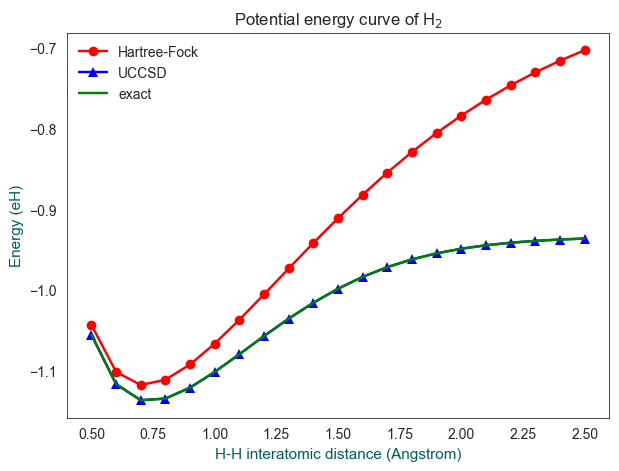

In [23]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.get_backend()
%matplotlib inline

plt.figure(figsize=(7,5))

plt.plot(h2_length, hf_e_list, color = 'red', label = 'Hartree-Fock', marker = 'o')
plt.plot(h2_length, uccsd_e_list, color = 'blue', label = 'UCCSD', marker = '^')
plt.plot(h2_length, exact_e_list, color = 'green', label = 'exact', marker = 'x')
plt.title('Potential energy curve of H$_2$')
plt.xlabel('H-H interatomic distance (Angstrom)')
plt.ylabel('Energy (eH)')
plt.legend()

<span style="font-size:10pt; font-weight:bold;"> &copy; Copyright IBM Corp. 2023 <br/>This content is categorized as an “existing” IBM asset as part of the IBM Quantum Accelerator contract. </span>